<a href="https://colab.research.google.com/github/HaqTetsuya/rusdi-prototype-1/blob/main/rusdi_prototype_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Teks judul default
# Cell 1: Instalasi library yang diperlukan
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
# @title Cell 2: Import library yang diperlukan
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from google.colab import drive, files

In [3]:
# @title Cell 3: Mount Google Drive untuk menyimpan model dan data
# Uncomment ini jika ingin menggunakan Google Drive

drive.mount('/content/drive')
MODEL_SAVE_PATH = "/content/drive/MyDrive/indobert_intent_model"

# Jika tidak ingin menggunakan Google Drive
MODEL_SAVE_PATH = "./indobert_intent_model"

# Cell 4: Kelas Dataset untuk IndoBERT
class IntentDataset(Dataset):
    """Dataset untuk klasifikasi intent dengan IndoBERT"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert dict of tensors to flat tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)

        return item



Mounted at /content/drive


In [4]:
# @title Cell 5: Fungsi untuk membuat contoh file CSV
def create_sample_csv(output_file="sample_intent_data.csv"):
    """Membuat contoh file CSV dengan data intent untuk demonstrasi"""

    data = {
        'text': [
            "Bagaimana cara meminjam buku di perpustakaan?",
            "Apa jam buka perpustakaan hari ini?",
            "Berapa lama masa peminjaman buku?",
            "Saya ingin memperpanjang peminjaman buku",
            "Bagaimana cara menjadi anggota perpustakaan?",
            "Berapa denda untuk keterlambatan pengembalian?",
            "Apakah perpustakaan mempunyai ruang belajar?",
            "Bagaimana cara mencari buku tentang sejarah Indonesia?",
            "Apakah perpustakaan memiliki layanan e-book?",
            "Saya kehilangan kartu anggota perpustakaan",
            "Bagaimana cara mengakses jurnal ilmiah?",
            "Dimana letak koleksi buku referensi?",
            "Apakah ada acara diskusi buku minggu ini?",
            "Berapa buku maksimal yang bisa dipinjam?",
            "Saya ingin memesan buku yang sedang dipinjam",
            "Apakah ada WiFi gratis di perpustakaan?",
            "Berapa biaya fotokopi dokumen di perpustakaan?",
            "Saya ingin mendonasikan buku ke perpustakaan",
            "Bagaimana cara menggunakan komputer di perpustakaan?",
            "Apakah perpustakaan punya koleksi tesis dan disertasi?",
            "Saya ingin mengajukan permintaan buku baru",
            "Bisakah saya meminjam buku antar-perpustakaan?",
            "Apa syarat menjadi anggota perpustakaan?",
            "Bagaimana cara mencari artikel jurnal?",
            "Apakah ada fasilitas printer di perpustakaan?",
            "Berapa lama waktu operasional perpustakaan?",
            "Saya ingin melaporkan kerusakan buku",
            "Bagaimana proses pengembalian buku?",
            "Apakah layanan peminjaman tersedia online?",
            "Dimana saya bisa menemukan kamus bahasa asing?"
        ],
        'intent': [
            "peminjaman_buku",
            "jam_operasional",
            "masa_peminjaman",
            "perpanjangan",
            "pendaftaran_anggota",
            "denda",
            "fasilitas",
            "pencarian_buku",
            "layanan_digital",
            "kehilangan_kartu",
            "akses_jurnal",
            "lokasi_koleksi",
            "agenda_perpustakaan",
            "kuota_peminjaman",
            "reservasi_buku",
            "fasilitas",
            "biaya_layanan",
            "donasi_buku",
            "penggunaan_fasilitas",
            "koleksi_khusus",
            "permintaan_buku",
            "peminjaman_antar_perpustakaan",
            "pendaftaran_anggota",
            "pencarian_jurnal",
            "fasilitas",
            "jam_operasional",
            "laporan_masalah",
            "pengembalian_buku",
            "layanan_online",
            "lokasi_koleksi"
        ]
    }

    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)
    print(f"File contoh CSV berhasil dibuat: {output_file}")
    return output_file


In [5]:

# @title Cell 6: Fungsi untuk memuat data dari CSV
def load_data_from_csv(csv_path):
    """Memuat data intent dari file CSV"""
    print(f"Memuat data dari: {csv_path}")

    # Cek apakah file ada
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File CSV tidak ditemukan: {csv_path}")

    # Memuat data
    try:
        df = pd.read_csv(csv_path)
        print(f"Berhasil memuat {len(df)} baris data")
    except Exception as e:
        raise Exception(f"Error saat memuat file CSV: {str(e)}")

    # Cek kolom yang diperlukan
    required_columns = ['text', 'intent']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Kolom '{col}' tidak ditemukan dalam file CSV")

    # Mengonversi label intent menjadi angka
    label_encoder = LabelEncoder()
    df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

    # Informasi tentang intent yang ditemukan
    intent_classes = label_encoder.classes_
    num_labels = len(intent_classes)
    print(f"Ditemukan {num_labels} intent berbeda dalam dataset")

    # Tampilkan distribusi intent
    intent_counts = df['intent'].value_counts()
    print("\nDistribusi intent:")
    for intent, count in intent_counts.items():
        print(f"  {intent}: {count} contoh")

    # Membagi data menjadi training dan validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['intent'])

    print(f"Data dibagi menjadi {len(train_df)} sampel training dan {len(val_df)} sampel validasi")

    # Menyiapkan data untuk pelatihan
    train_texts = train_df['text'].values
    train_labels = train_df['intent_encoded'].values
    val_texts = val_df['text'].values
    val_labels = val_df['intent_encoded'].values

    return train_texts, val_texts, train_labels, val_labels, intent_classes, num_labels, label_encoder


In [6]:
# @title Cell 7: Fungsi untuk setup model IndoBERT
def setup_indobert_for_intent(num_labels):
    """Load model IndoBERT untuk klasifikasi intent"""

    print("Memuat model IndoBERT...")
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    model = AutoModelForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p1",
        num_labels=num_labels
    )
    print("Model berhasil dimuat")

    return model, tokenizer

In [7]:
# @title Cell 8: Fungsi untuk pelatihan model
def train_intent_classifier(model, tokenizer, train_texts, train_labels, val_texts, val_labels,
                           batch_size=16, epochs=5, learning_rate=5e-5, save_path=MODEL_SAVE_PATH):
    """Melatih model IndoBERT untuk klasifikasi intent"""

    # Persiapkan dataset
    print("Menyiapkan dataset...")
    train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Optimizer dan scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Cek untuk GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan device: {device}")
    model.to(device)

    print(f"Mulai pelatihan model...")
    print(f"Total epoch: {epochs}, batch size: {batch_size}")

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

        for batch in progress_bar:
            # Pindahkan batch ke device
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        with torch.no_grad():
            for batch in progress_bar:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                # Hitung akurasi
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

                progress_bar.set_postfix({'loss': loss.item()})

        avg_val_loss = val_loss / len(val_dataloader)
        accuracy = correct / total

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy*100:.2f}%")

        # Simpan model terbaik
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            print(f"Menyimpan model terbaik ke {save_path}")
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)

    print(f"Pelatihan selesai! Model terbaik disimpan di {save_path}")

    # Plot hasil training
    plt.figure(figsize=(12, 4))

    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot 2: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Akurasi selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history



In [8]:
# @title Cell 9: Fungsi untuk evaluasi model
def evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes, batch_size=16):
    """Evaluasi model dan tampilkan confusion matrix dan metrics"""

    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluasi"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=intent_classes, digits=4)
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=intent_classes, yticklabels=intent_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return report, cm


In [14]:
# @title Cell 10: Fungsi untuk prediksi intent
def predict_intent(text, model, tokenizer, intent_classes, label_encoder=None, device=None):
    """Memprediksi intent dari teks input"""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    predicted_intent = intent_classes[prediction]

    # Dapatkan top 3 intent dengan confidence tertinggi
    top_k = 3
    if len(intent_classes) < top_k:
        top_k = len(intent_classes)

    topk_values, topk_indices = torch.topk(probabilities, top_k, dim=1)
    topk_intents = [(intent_classes[idx.item()], val.item()) for idx, val in zip(topk_indices[0], topk_values[0])]

    return predicted_intent, confidence, topk_intents

In [15]:
# @title Cell 11: Fungsi untuk menyiapkan dan melatih model
def run_full_pipeline():
    """Jalankan pipeline lengkap: buat contoh, latih model, evaluasi"""
    # 1. Buat atau muat dataset
    csv_file = "sample_intent_data.csv"
    if not os.path.exists(csv_file):
        csv_file = create_sample_csv(csv_file)

    # 2. Upload file CSV dari lokal jika diperlukan
    """
    # Uncomment jika ingin upload file CSV Anda sendiri
    print("Upload file CSV Anda:")
    uploaded = files.upload()
    csv_file = next(iter(uploaded.keys()))
    """

    # 3. Muat data
    train_texts, val_texts, train_labels, val_labels, intent_classes, num_labels, label_encoder = load_data_from_csv(csv_file)

    # 4. Setup model
    model, tokenizer = setup_indobert_for_intent(num_labels)

    # 5. Latih model
    model, history = train_intent_classifier(
        model, tokenizer, train_texts, train_labels, val_texts, val_labels,
        batch_size=8, epochs=3, learning_rate=2e-5
    )

    # 6. Evaluasi model
    report, cm = evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes)

    # 7. Simpan kelas intent dan label encoder untuk keperluan prediksi
    import pickle
    with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "wb") as f:
        pickle.dump(intent_classes, f)

    with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    # 8. Tampilkan hasil
    print(f"\nModel telah berhasil dilatih dan disimpan di {MODEL_SAVE_PATH}")
    print(f"Jumlah intent: {num_labels}")
    print(f"Intent yang didukung: {', '.join(intent_classes)}")

    return model, tokenizer, intent_classes, label_encoder


In [21]:
# @title Cell 12: Fungsi untuk demo prediksi
def run_prediction_demo(model=None, tokenizer=None, intent_classes=None, label_encoder=None):
    """Jalankan demo prediksi intent dengan model yang telah dilatih"""

    # Jika model tidak diberikan, muat dari path penyimpanan
    if model is None or tokenizer is None or intent_classes is None:
        if not os.path.exists(MODEL_SAVE_PATH):
            print(f"Error: Model tidak ditemukan di {MODEL_SAVE_PATH}")
            print("Jalankan run_full_pipeline() terlebih dahulu untuk melatih model")
            return

        # Muat model dan tokenizer
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
        tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)

        # Muat intent classes
        import pickle
        with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "rb") as f:
            intent_classes = pickle.load(f)

    # Contoh pertanyaan untuk demo
    test_texts = [
            # GREETING Variations
            "Hai, pagi gaes!",
            "misi, ini bener bot perpustakaan?",
            "bray, bisa nanya dikit?",
            "hallo min, gw mau tanya",
            "siang boskuu",
            "yo bro, ada info buku ga?",
            "salam kenal bot",
            "met siang, bantuin dong",
            "heh, ada yang bisa dijawab?",
            "woy, sini bentar dong",
            "permisi gan, bisa bantu?",
            "euy, ada orang?",
            "yo, bantuin gw dong!",
            "allo, chatbot kan?",
            "mlm bot, lg ngapain?",

            # GOODBYE Variations
            "oke deh, gua cabut",
            "thx yaa, caw dulu",
            "makasih banyak, bye bye",
            "tengkyu, out duluan",
            "okeeeh, sampai ketemu lagi!",
            "gasss, gw pergi",
            "arigato, adios!",
            "sip, gw logout dulu",
            "thanks bro, gw left",
            "udah cukup, gw berangkat",
            "yawdah gw undur diri",
            "see u besok, cuy",
            "met tinggal bot!",
            "gw pegi dlu ye",
            "ok bos, keluar dulu"
    ]

    print("Demo Prediksi Intent:")

    # Prediksi dari contoh
    for text in test_texts:
        intent, confidence, topk = predict_intent(text, model, tokenizer, intent_classes)
        print(f"\nInput: \"{text}\"")
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

    # Prediksi input pengguna
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        intent, confidence, topk = predict_intent(user_input, model, tokenizer, intent_classes)
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")



Memuat data dari: sample_intent_data.csv
Berhasil memuat 995 baris data
Ditemukan 2 intent berbeda dalam dataset

Distribusi intent:
  goodbye: 500 contoh
  greeting: 495 contoh
Data dibagi menjadi 796 sampel training dan 199 sampel validasi
Memuat model IndoBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model berhasil dimuat
Menyiapkan dataset...
Menggunakan device: cuda
Mulai pelatihan model...
Total epoch: 3, batch size: 8


Epoch 1/3 [Training]:   0%|          | 0/100 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1/3 [Validation]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.1200, Val Loss: 0.0617, Val Accuracy: 98.49%
Menyimpan model terbaik ke ./indobert_intent_model


Epoch 2/3 [Training]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2/3 [Validation]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.0278, Val Loss: 0.0448, Val Accuracy: 98.99%
Menyimpan model terbaik ke ./indobert_intent_model


Epoch 3/3 [Training]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3/3 [Validation]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.0134, Val Loss: 0.0352, Val Accuracy: 99.50%
Menyimpan model terbaik ke ./indobert_intent_model
Pelatihan selesai! Model terbaik disimpan di ./indobert_intent_model


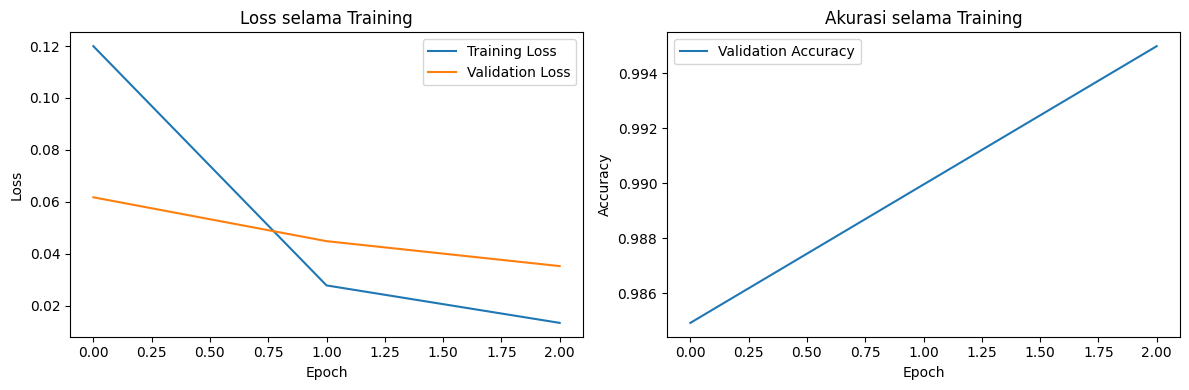

Evaluasi:   0%|          | 0/13 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

     goodbye     1.0000    0.9900    0.9950       100
    greeting     0.9900    1.0000    0.9950        99

    accuracy                         0.9950       199
   macro avg     0.9950    0.9950    0.9950       199
weighted avg     0.9950    0.9950    0.9950       199



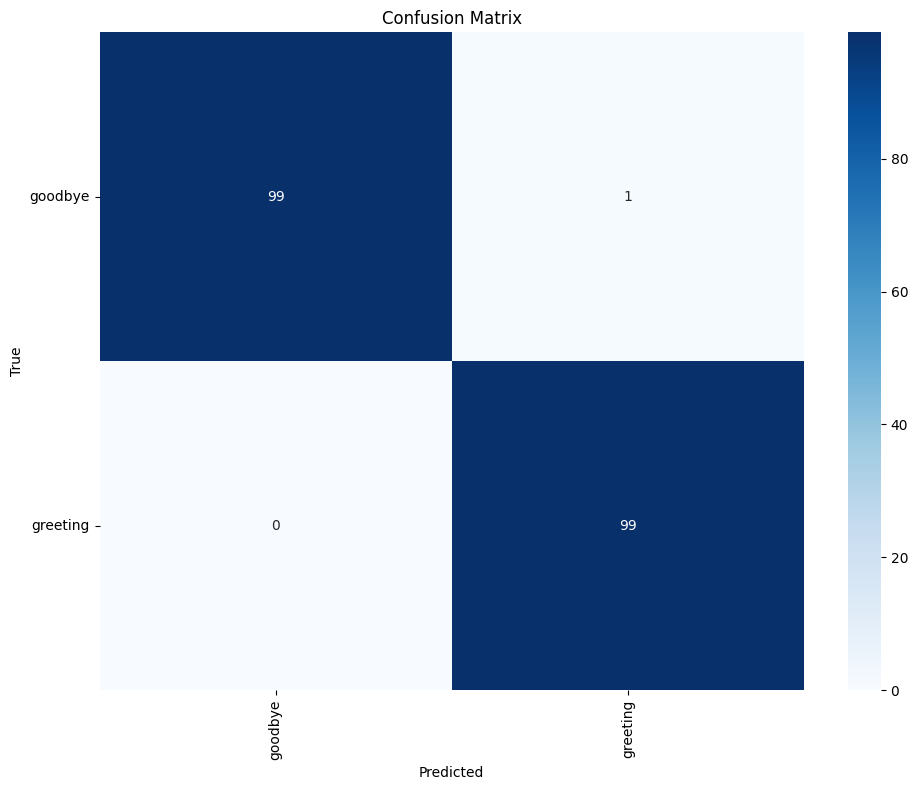


Model telah berhasil dilatih dan disimpan di ./indobert_intent_model
Jumlah intent: 2
Intent yang didukung: goodbye, greeting


In [17]:
# Cell 13: Jalankan pipeline (uncomment untuk menjalankan)

model, tokenizer, intent_classes, label_encoder = run_full_pipeline()


# Cell 14: Jalankan demo prediksi (uncomment untuk menjalankan)


In [ ]:

run_prediction_demo(model, tokenizer, intent_classes, label_encoder)


Demo Prediksi Intent:

Input: "Hai, pagi gaes!"
Intent terdeteksi: greeting (confidence: 0.9990)
Top 3 intent:
  1. greeting: 0.9990
  2. goodbye: 0.0010

Input: "misi, ini bener bot perpustakaan?"
Intent terdeteksi: greeting (confidence: 0.9992)
Top 3 intent:
  1. greeting: 0.9992
  2. goodbye: 0.0008

Input: "bray, bisa nanya dikit?"
Intent terdeteksi: greeting (confidence: 0.9992)
Top 3 intent:
  1. greeting: 0.9992
  2. goodbye: 0.0008

Input: "hallo min, gw mau tanya"
Intent terdeteksi: greeting (confidence: 0.9988)
Top 3 intent:
  1. greeting: 0.9988
  2. goodbye: 0.0012

Input: "siang boskuu"
Intent terdeteksi: greeting (confidence: 0.9993)
Top 3 intent:
  1. greeting: 0.9993
  2. goodbye: 0.0007

Input: "yo bro, ada info buku ga?"
Intent terdeteksi: greeting (confidence: 0.9975)
Top 3 intent:
  1. greeting: 0.9975
  2. goodbye: 0.0025

Input: "salam kenal bot"
Intent terdeteksi: greeting (confidence: 0.9989)
Top 3 intent:
  1. greeting: 0.9989
  2. goodbye: 0.0011

Input: "met 

In [13]:
# @title nigga
import pandas as pd
import random
from deep_translator import GoogleTranslator
from nltk.corpus import wordnet
import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')

# Load dataset
file_path = "/content/aaa.csv"  # Sesuaikan dengan lokasi file
df = pd.read_csv(file_path)

# Fungsi untuk mendapatkan sinonim dari WordNet
def get_synonym(word):
    synonyms = set()
    for syn in wordnet.synsets(word, lang='ind'):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Fungsi untuk mengganti kata dengan sinonim
def replace_with_synonym(sentence):
    words = sentence.split()
    new_words = [random.choice(get_synonym(word)) if get_synonym(word) else word for word in words]
    return " ".join(new_words)

# Fungsi untuk backtranslation
def back_translate(sentence):
    translated = GoogleTranslator(source='id', target='en').translate(sentence)
    return GoogleTranslator(source='en', target='id').translate(translated)

# Fungsi untuk menambahkan noise (typo simulasi)
def add_typo(sentence):
    chars = list(sentence)
    if len(chars) > 3:
        idx = random.randint(0, len(chars) - 1)
        chars[idx] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)

# Fungsi untuk augmentasi data
def augment_data(text):
    augmented_texts = []
    augmented_texts.append(text)  # Data asli
    augmented_texts.append(replace_with_synonym(text))  # Sinonim
    augmented_texts.append(back_translate(text))  # Backtranslation
    augmented_texts.append(add_typo(text))  # Typo
    augmented_texts.append(text + random.choice([" dong", " ya", " lho", " bro"]))  # Tambah kata
    return augmented_texts

# Proses augmentasi
augmented_rows = []
for _, row in df.iterrows():
    texts = augment_data(row['text'])
    for new_text in texts:
        augmented_rows.append([new_text, row['intent']])

# Simpan dataset baru
augmented_df = pd.DataFrame(augmented_rows, columns=["text", "intent"])
augmented_df.to_csv("/content/sample_intent_data.csv", index=False)

print("✅ Augmentasi selesai! Dataset baru tersimpan sebagai 'augmented_data.csv'.")


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Augmentasi selesai! Dataset baru tersimpan sebagai 'augmented_data.csv'.


In [ ]:
!pip install deep-translator
